In [423]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

In [269]:
def unzip(file):
    if os.path.exists(file):
        pass
    else:
        with zipfile.ZipFile(file) as zf:
            zf.extractall()

In [16]:
unzip('titanic.zip')

In [18]:
os.listdir()

['.ipynb_checkpoints',
 'Assignment 3.ipynb',
 'gender_submission.csv',
 'test.csv',
 'titanic.zip',
 'train.csv']

In [689]:
df_train = pd.read_csv('train.csv',index_col = 0)
df_gender = pd.read_csv('gender_submission.csv')
df_test = pd.read_csv('test.csv')

In [217]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [218]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [219]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [66]:
def data_types(data):
    data['Survived'].astype(int)

In [67]:
data_types(df_train)

In [679]:
def graphs(data):
    fig,axes = plt.subplots(3,2,figsize=(15,20))
    sns.heatmap(data.corr(),cmap = 'coolwarm',annot=True,ax = axes[0,0]).set_title('Correlations')
    sns.countplot(y='Pclass',hue = 'Survived',data = data,ax = axes[0,1]).set_title('Pclass by Survived')
    sns.countplot(y='Survived',data = data,ax = axes[1,0]).set_title('Survived')
    sns.catplot(x='Survived',y='Age',kind='box',data=data,ax=axes[1,1])
    axes[1,1].set_title('Suvived by Age')
    sns.relplot(x='Age',y='Fare',hue='Survived',data=data,ax=axes[2,0])
    axes[2,0].set_title('Age by Fare based on Survived')
    sns.countplot(y='Sex',hue = 'Survived',data = data,ax = axes[2,1])
    axes[2,1].set_title('Sex by Survived')
    plt.close(2)
    plt.close(3)

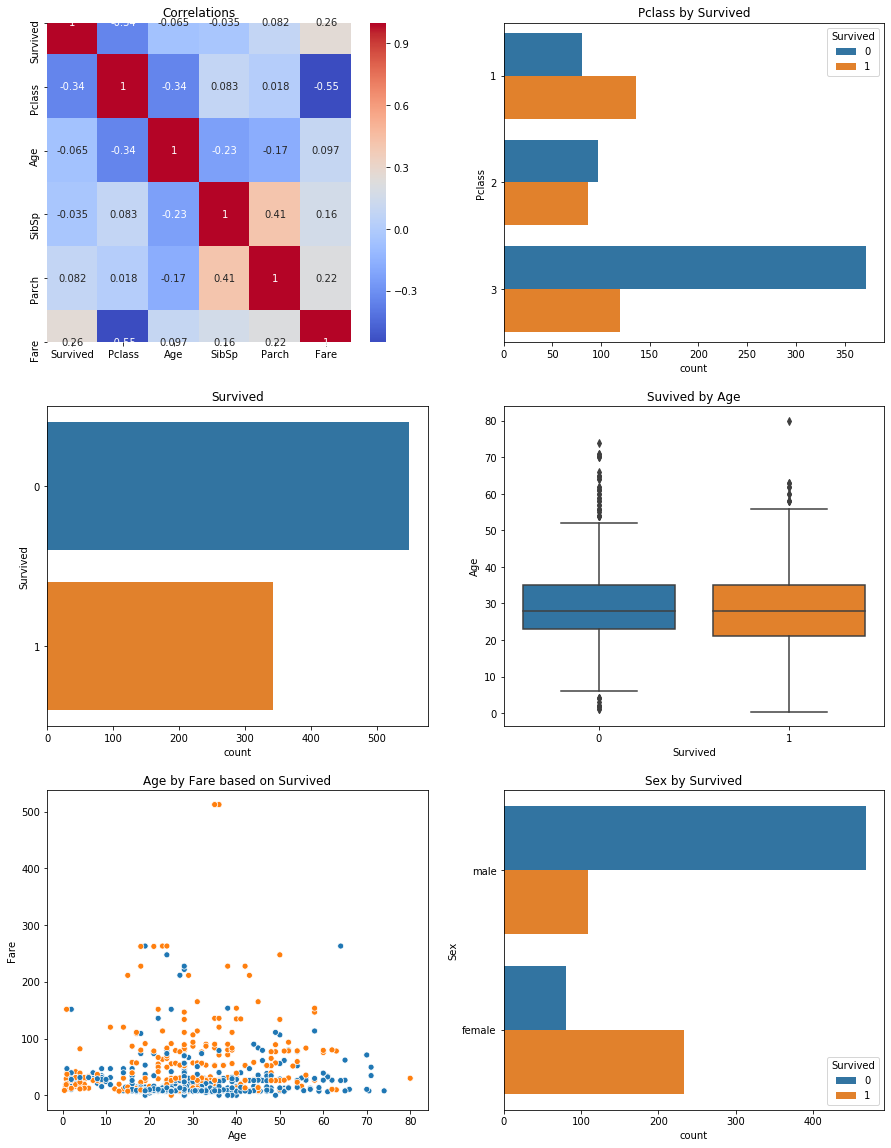

In [680]:
graphs(df_train)

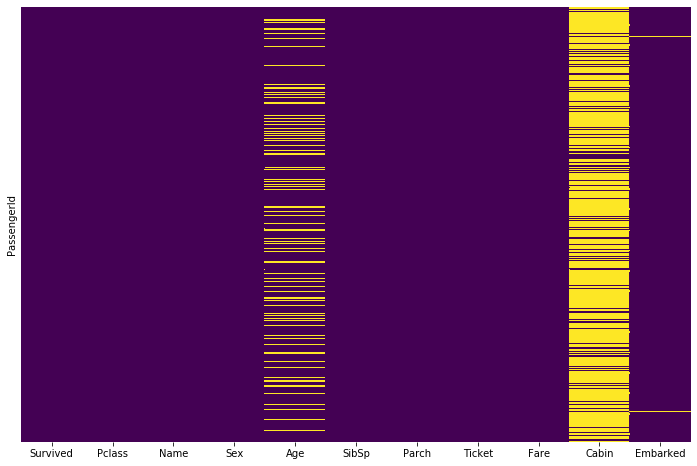

In [224]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.isnull(),cbar=False,cmap='viridis',yticklabels=False)

In [231]:
df_train.isnull().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
Survived      0
dtype: int64

In [701]:
def null_values(data):
    data.drop('Cabin',inplace=True,axis=1)
    data['Age'].fillna(data['Age'].median(),inplace=True)
    data['Embarked'].fillna('S',inplace=True)
    data['Fare'].fillna(data['Fare'].mean(),inplace=True)
    data.drop('Name',inplace=True,axis=1)
    data.drop('Ticket',inplace=True,axis=1)

In [325]:
null_values(df_train)

In [381]:
def standardize_fields(data):
    
    num_columns = ['Age','Fare']
    cat_columns = ['Pclass','Sex','SibSp','Parch','Embarked']
            
    scaler = StandardScaler()
    scaled_num_col = scaler.fit_transform(data.loc[:,num_columns])
    scaled_num_col = pd.DataFrame(scaled_num_col,columns=['Age','Fare'],index=data.index)
    
    label_enc = LabelEncoder()
    enc_cat_col = data.loc[:,cat_columns].apply(LabelEncoder().fit_transform)
    
    standardized_fields = enc_cat_col.join(scaled_num_col)
                       
    return standardized_fields

In [383]:
X_train, X_test, y_train, y_test = train_test_split(standardize_fields(df_train), df_train['Survived'],
    test_size=0.25, random_state=42)

In [459]:
def train_models(x,y,cv):
    estimators = [RandomForestClassifier(100,random_state=42),LogisticRegression(solver= 'lbfgs'),KNeighborsClassifier(n_neighbors=5),
             svm.SVC(gamma='auto'),GaussianNB()]
    scoring = 'roc_auc'
    predictions = []
    results = []
    estimator_names = []
    
    for estimator in estimators:
        predictions.append(cross_val_predict(estimator,x,y,cv=cv))
        results.append(cross_val_score(estimator,x,y,cv=cv,scoring=scoring))
        estimator_names.append(str(estimator).split('(')[0])
    
    predictions = pd.DataFrame(predictions,index=estimator_names).transpose()
    results = pd.DataFrame(results,index=estimator_names).transpose()
    
    trained_models = {}
    trained_models['predictions'] = predictions
    trained_models['results'] = results
        
    return trained_models

In [563]:
trained_models['predictions'].head()

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,SVC,GaussianNB
0,1,0,0,0,0
1,0,0,0,0,0
2,1,1,1,1,1
3,0,0,0,0,0
4,1,1,0,1,1


In [668]:
trained_models['results']

,RandomForestClassifier,LogisticRegression,KNeighborsClassifier,SVC,GaussianNB
0,0.871262,0.825914,0.813289,0.818605,0.807309
1,0.847308,0.861974,0.837992,0.852312,0.869910
2,0.840580,0.858178,0.810214,0.806073,0.832298
3,0.816080,0.782264,0.772774,0.810904,0.783644
4,0.880262,0.821601,0.849379,0.832988,0.788475
5,0.867840,0.902001,0.841442,0.849551,0.889579


In [669]:
trained_models['results'].mean()

RandomForestClassifier    0.853889
LogisticRegression        0.841989
KNeighborsClassifier      0.820848
SVC                       0.828406
GaussianNB                0.828536
dtype: float64

In [665]:
def roc_curve_plot(X_train,y_train,X_test,y_test):
    estimators = [RandomForestClassifier(100,random_state=42),LogisticRegression(solver= 'lbfgs'),KNeighborsClassifier(n_neighbors=5),
         svm.SVC(gamma='auto'),GaussianNB()]
    predictions = []
    results = []
    estimator_names = []
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=[10,6])
    
    for estimator in estimators:
        model = estimator.fit(X_train,y_train)
        pred = model.predict(X_train)
        fpr,tpr,thresholds = roc_curve(y_train,pred)
        
        ax1.plot(fpr,tpr,label=str(estimator).split('(')[0])
        ax1.plot([0,1],[0,1],'k--')
        ax1.axis([0,1,0,1])
        ax1.set_title("ROC Train Score")
        ax1.legend()
        
        pred_test = model.predict(X_test)
        fpr_test,tpr_test,thresholds = roc_curve(y_test,pred_test)
        ax2.plot(fpr_test,tpr_test,label=str(estimator).split('(')[0])
        ax2.plot([0,1],[0,1],'k--')
        ax2.axis([0,1,0,1])
        ax2.set_title("ROC Test Score")
        ax2.legend()

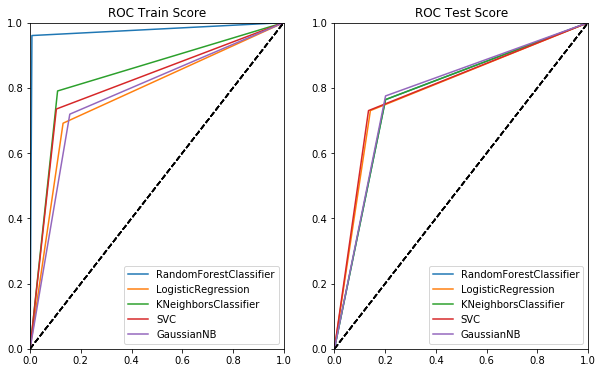

In [667]:
roc_curve_plot(X_train,y_train,X_test,y_test)

In [512]:
results_tograph = pd.DataFrame(trained_models['results'].stack())
results_tograph.reset_index(inplace=True)
results_tograph.columns= ['cv','estimator','score']

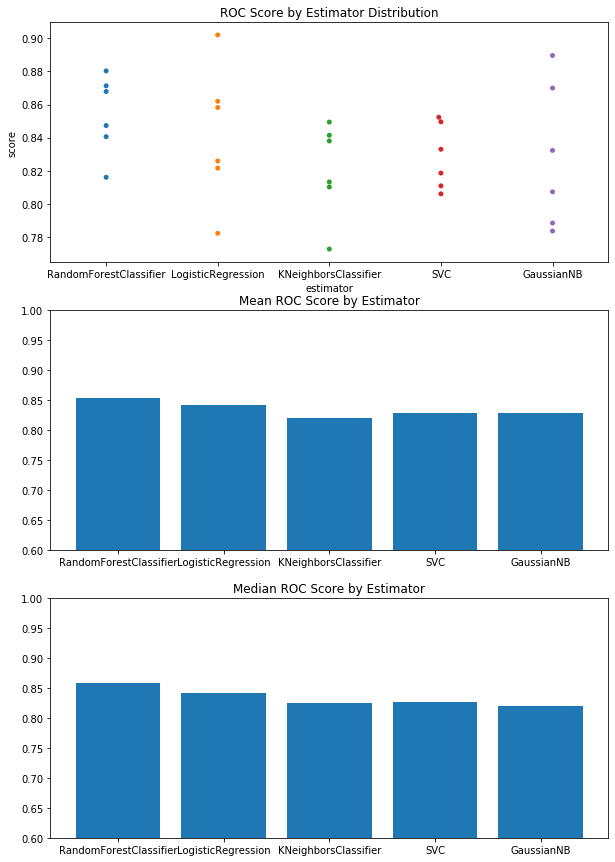

In [681]:
fig,axes = plt.subplots(3,figsize=(10,15))
sns.catplot(x='estimator',y='score',data=results_tograph,kind='swarm',ax=axes[0])
axes[0].set_title('ROC Score by Estimator Distribution')
axes[1].bar(trained_models['results'].columns,trained_models['results'].mean())
axes[1].set_ylim(.6,1)
axes[1].set_title('Mean ROC Score by Estimator')
axes[2].bar(trained_models['results'].columns,trained_models['results'].median())
axes[2].set_ylim(.6,1)
axes[2].set_title('Median ROC Score by Estimator')
plt.close(2)

In [728]:
#Logistic Regression
df_test = pd.read_csv('test.csv')
null_values(df_test)
log_fit = LogisticRegression().fit(X_train,y_train)
pred = log_fit.predict(standardize_fields(df_test))
test_1 = pd.DataFrame(df_test['PassengerId']).join(pd.DataFrame(pred,columns=['Survived']))
test_1 = test_1.to_csv('test_1.csv',header=True,index=None,sep=',')

C:\Users\Joshua\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
